In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
import haloclustering.models as models
from haloclustering.data import get_combined_dataset
import haloclustering.evalulate_model as evaluate
import numpy as np
import matplotlib.pyplot as plt
import corner

## Load in the combined CGM$^{2}$ and CASBaH data

In [2]:
cgmsqfile = "/Users/mwilde/python/cgm-squared/cgmsquared/data/cgm/cgmsquared_cgmsurvey_aodm_vhalos10_3sigma.json"
casdir = "/Users/mwilde/Dropbox/CASBaH/data/h1_galaxies_20Mpc_500kms_*.fits"
data = get_combined_dataset(cgmsqfile, casdir, rho_min=0.)

read_sets: Using set file -- 
  /Users/mwilde/python/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 1389
misses 5509
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 268
misses 291


# define the model


$\chi_{\perp}^{2h}$


$\xi = (r/r_0)^{\gamma}$


$\chi_{\perp} = \int \xi ds$

rate of incidence = $\lambda$



$f_c = 1 - \exp(-\lambda)$

$\lambda = (1 + [\chi_{\perp}^{2h}(r|r^{2h}_0, \gamma^{2h})])~\langle dN/dz | C_0, \alpha \rangle \delta z$

$\langle dN/dz\rangle = C_0(1 + z)^{\alpha}$

In [3]:
r_0 = 4
gamma_initial = 1.7
beta_initial = 0.25
dndz_index = 1.2 # dN/dz powerlaw index
dndz_coeff = 27
initial = np.array([r_0, gamma_initial, beta_initial, dndz_index, dndz_coeff])
bounds = ((0, 10), (0, 2), (-3, 10), (-3, 3), (0, 35))


In [5]:
# instantiate the model
model1hBeta = models.Model2hBeta(data)

In [6]:
soln = evaluate.max_likelihood_est(model1hBeta, initial, bounds)
r0, gamma, beta, dndz_index, dndz_coeff = soln.x

print('\n')
print("Maximum likelihood estimates:")
print("=============================")
print("r0 = {0:.3f}".format(r0))
print("gamma = {0:.3f}".format(gamma))
print("beta = {0:.3f}".format(beta))
print('dndz_index = {0:.3f}'.format(dndz_index))
print('dndz_index = {0:.3f}'.format(dndz_coeff))
print("=============================")

/Users/mwilde/python/cgm-squared/cgmsquared/clustering2.py:188: RuntimeWarning: divide by zero encountered in true_divide
  (x * (np.sqrt(r ** 2 + x ** 2) / r0) ** (-g))




Maximum likelihood estimates:
r0 = 3.627
gamma = 1.615
beta = 0.062
dndz_index = 1.103
dndz_index = 27.124


In [7]:
sampler = evaluate.posterior_sampler(soln, model1hBeta.log_probability, nsteps=4000)

100%|██████████| 4000/4000 [03:30<00:00, 19.00it/s]


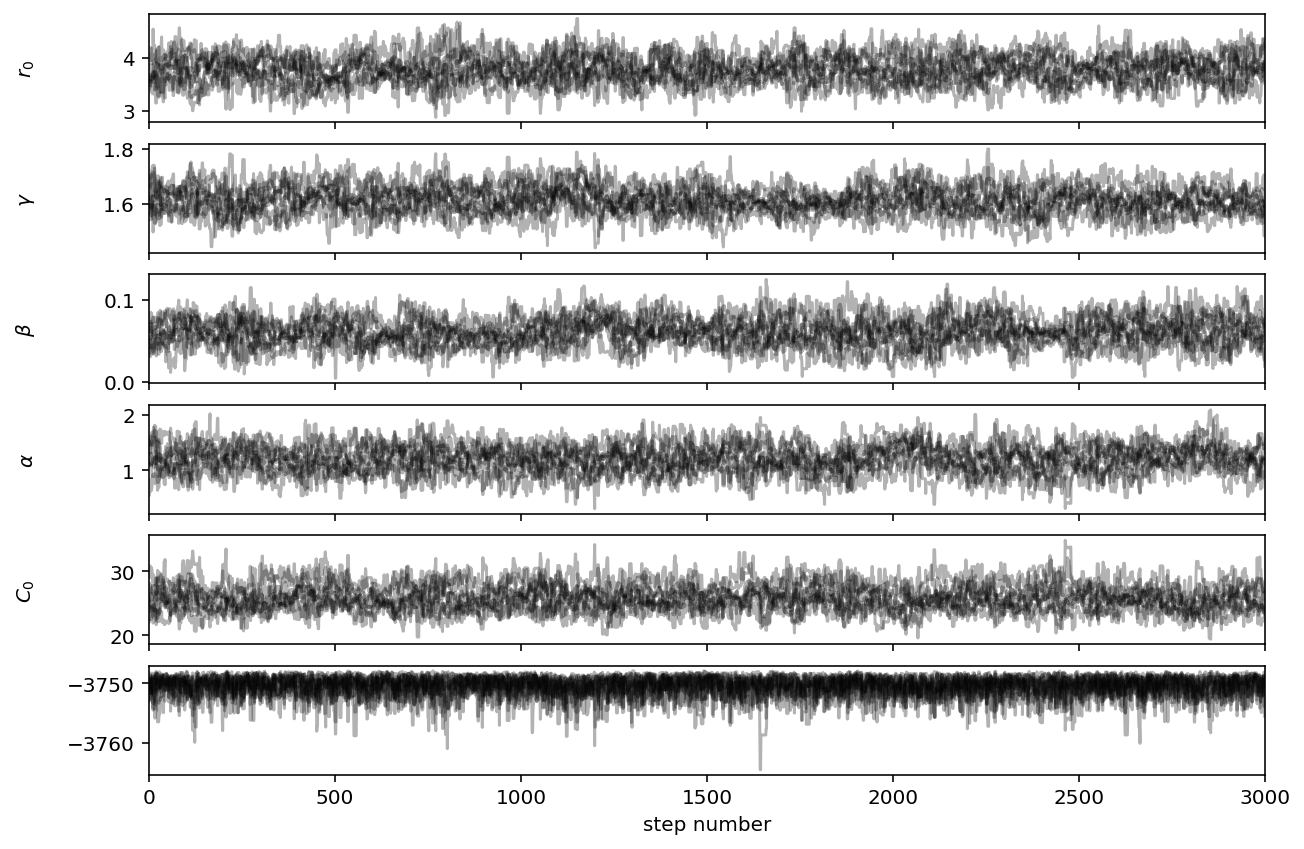

In [8]:
discard = 1000
samples = sampler.get_chain(discard=discard)
flat_samples = sampler.get_chain(discard=discard, thin=1, flat=True)
ndim = samples.shape[2]

# plot
fig, axes = plt.subplots(nrows=ndim+1, figsize=(10, 7), sharex=True)
labels = [r"$r_0$", r"$\gamma$", r'$\beta$', r'$\alpha$', r'$C_0$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

axes[-1].plot(sampler.lnprobability.T[discard:], "k", alpha=0.3);

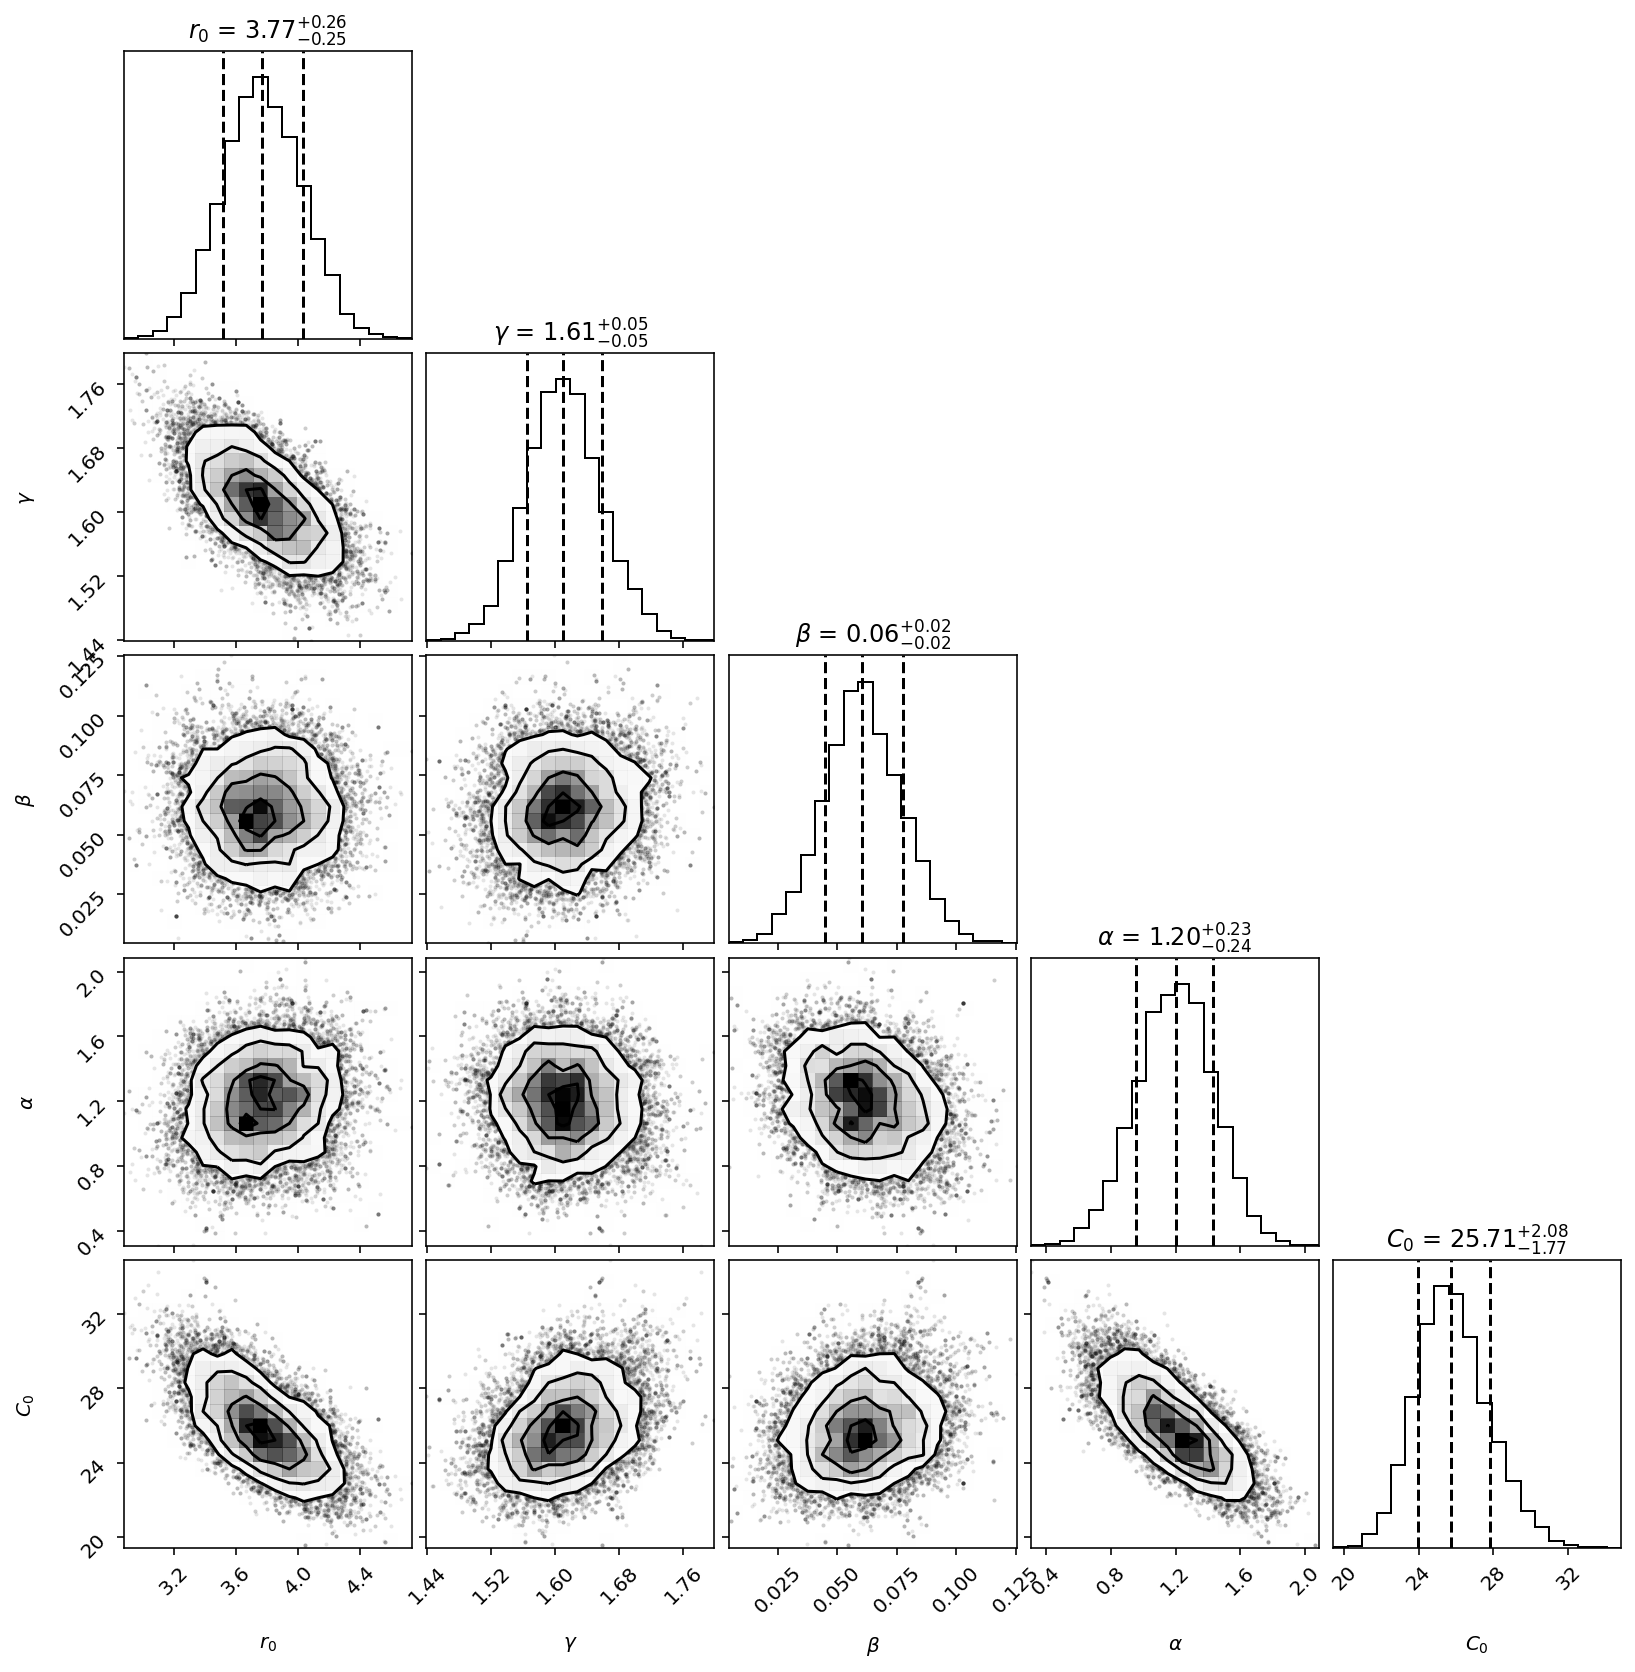

In [9]:
fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}
);
fig.savefig('corner_2h_with_beta.png')

In [10]:
import pickle
# save the sampler    
with open("model_2h_only_with_beta_sampler.pkl", "wb") as f:
    pickle.dump(sampler, f)